<a href="https://colab.research.google.com/github/RicardoMourao-py/INFORMACOES_GEORREFERENCIADAS/blob/main/projeto_infogeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Como a localização das unidades de atendimento Bom Prato no estado de São Paulo atende às regiões com maior número de famílias em situação de rua?

A pergunta busca entender se as unidades Bom Prato estão distribuídas de maneira estratégica para atender as populações mais vulneráveis, em especial famílias em situação de rua. Esse insight pode ajudar a identificar possíveis lacunas na cobertura dos serviços, especialmente nas áreas com alta concentração de famílias em situação de vulnerabilidade.



## Instalando bibliotecas

In [1]:
!pip install geopandas --quiet
!pip install geopy --quiet
!pip install pointpats==2.3.0 --quiet
!pip install fiona --quiet
!pip install seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 85.3 MB/s eta 0:00:00


## Importando Bibliotecas

In [16]:
import geopandas as gpd
import fiona as f
from pointpats import PointPattern
import matplotlib.pyplot as plt
import os
import numpy as np
from pointpats.centrography import mean_center, weighted_mean_center, std_distance, ellipse
from matplotlib.patches import Ellipse
from pointpats import hull
import pointpats.quadrat_statistics as qs
import seaborn as sns
import math
from pointpats.distance_statistics import K
from pointpats import PoissonPointProcess
import itertools
from pointpats.distance_statistics import Kenv
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Equipamento Bom Prato vs Cadastro Único

- Quantos bom prato atende aquele município ?
- Tem que definir o raio, pois pessoas de outro município podem ir para um bom prato de outro devido ao raio de distância.

In [5]:
# Votos para o Brexit
# !wget --no-check-certificate https://repositorio.seade.gov.br/dataset/ba6b40e3-9bfe-4bb6-a741-d9436b0312a2/resource/4cd70073-7a54-4116-bbfb-552764e385f7/download/bomprato.zip
# !wget --no-check-certificate https://repositorio.seade.gov.br/dataset/7bb1a33a-7600-42fd-ad4d-33e9d4734a37/resource/6913ebd1-3518-47d1-abbd-2b6ce30152ce/download/ppa_oe04_ge203.zip
!unzip bomprato.zip
!unzip ppa_oe04_ge203.zip


Archive:  bomprato.zip
 extracting: Bomprato.cpg            
  inflating: Bomprato.dbf            
  inflating: Bomprato.prj            
  inflating: Bomprato.qmd            
  inflating: Bomprato.shp            
  inflating: Bomprato.shx            
  inflating: Bomprato.xlsx           
Archive:  ppa_oe04_ge203.zip
  inflating: PPA_OE04_ge203.xlsx     
  inflating: PPA_OE04_ge203.cpg      
  inflating: PPA_OE04_ge203.dbf      
  inflating: PPA_OE04_ge203.prj      
  inflating: PPA_OE04_ge203.qmd      
  inflating: PPA_OE04_ge203.shp      
  inflating: PPA_OE04_ge203.shx      


In [99]:
bom_prato = gpd.read_file('Bomprato.shp')
cad_unico = gpd.read_file('PPA_OE04_ge203.shp')

In [100]:
bom_prato

,Item,tipo,endereco,municipio,regiao,lat,long,geometry
0,16,BP_FIXO,"Avenida Antônio Sylvio Cunha Bueno, 1904",Diadema,RMPS,-23.722221,-46.616250,POINT (-46.61625 -23.72222)
1,46,BP_FIXO,"Rua Dr. Arnaldo Miraglia, nº quadra 06",Bauru,interior,-22.314090,-49.123995,POINT (-49.12399 -22.31409)
2,47,BP_FIXO,"Rua Mauá, 66",São Paulo,Capital,-23.535079,-46.639350,POINT (-46.63935 -23.53508)
3,66,BP_FIXO,"ETECRI México 70 - Rua do Canal, 582 - Vila Ma...",São Vicente,interior,-23.973035,-46.405382,POINT (-46.40538 -23.97304)
4,67,BP_FIXO,"Praça Nossa Senhora Aparecida, Vila Nossa Senh...",São Vicente,interior,-23.973035,-46.403922,POINT (-46.40392 -23.97304)
...,...,...,...,...,...,...,...,...
70,35,BP_FIXO,"Rua Presidente Roosevelt, 126",Limeira,interior,-22.569664,-47.401887,POINT (-47.40189 -22.56966)
71,37,BP_FIXO,"R. Antônio Arenso, 55",São Paulo,Capital,-23.673592,-46.742449,POINT (-46.74245 -23.67359)
72,44,BP_FIXO,"Av. Doutor Vicente de Carvalho, 876",Praia Grande,interior,-24.024066,-46.479923,POINT (-46.47992 -24.02407)
73,49,BP_FIXO,"Avenida Governador Lucas Nogueira Garcez, 500",Ribeirão Preto,interior,-21.157752,-47.846369,POINT (-47.84637 -21.15775)


In [62]:
cad_unico

,Cod_ibge,municipio,de201,ge101,ge107,ge116,ge201,ge202,ge203,in101,in201,ra101,ra102,ra103,sn0103,sn0104,geometry
0,3509908,Cananéia,24.1,1.7,15,85.3,508.1,0.0,77.6,48.8,0.0,1145,780,117,85.2,30.9,"POLYGON ((-47.83033 -24.75638, -47.83013 -24.7..."
1,3520426,Ilha Comprida,21.1,2.7,5,70.7,496.0,0.0,66.4,65.2,7.9,1125,735,158,60.0,NaN,"POLYGON ((-47.4366 -24.67434, -47.43638 -24.67..."
2,3505401,Barra do Turvo,17.5,1.6,0,76.3,202.0,0.0,75.6,55.8,9.0,485,279,33,94.8,90.2,"POLYGON ((-48.44457 -24.65134, -48.44418 -24.6..."
3,3509254,Cajati,9.2,2.3,61,60.5,355.5,0.0,72.2,65.6,0.0,6448,2842,226,83.2,274.9,"POLYGON ((-48.1556 -24.64078, -48.15505 -24.64..."
4,3524600,Jacupiranga,5.6,1.4,21,71.0,343.8,0.0,76.6,53.7,0.0,2962,1970,216,93.9,0.0,"POLYGON ((-48.00104 -24.5716, -48.0004 -24.572..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,3530003,Mira Estrela,0.0,3.7,0,8.8,385.7,0.0,54.1,70.0,0.0,277,171,8,100.0,25.0,"POLYGON ((-50.10224 -19.87441, -50.09732 -19.8..."
641,3520707,Indiaporã,0.0,2.3,0,9.5,311.4,0.0,60.9,67.9,0.0,382,223,7,97.8,400.0,"POLYGON ((-50.20045 -19.86626, -50.19701 -19.8..."
642,3529658,Mesópolis,0.0,2.8,0,7.9,293.5,0.0,60.3,75.0,0.0,116,69,0,98.2,37.0,"POLYGON ((-50.61347 -19.86537, -50.61346 -19.8..."
643,3534757,Ouroeste,11.1,2.6,6,13.1,282.3,0.0,55.0,77.6,0.0,2045,639,26,100.0,228.0,"POLYGON ((-50.44955 -19.78895, -50.44771 -19.7..."


In [10]:
# Renomear colunas do DataFrame 'cad_unico'
cad_unico = cad_unico.rename(columns={'Municipio': 'municipio'})

cad_unico.head(5)

,Cod_ibge,municipio,de201,ge101,ge107,ge116,ge201,ge202,ge203,in101,in201,ra101,ra102,ra103,sn0103,sn0104,geometry
0,3509908,Cananéia,24.1,1.7,15,85.3,508.1,0.0,77.6,48.8,0.0,1145,780,117,85.2,30.9,"POLYGON ((-47.83033 -24.75638, -47.83013 -24.7..."
1,3520426,Ilha Comprida,21.1,2.7,5,70.7,496.0,0.0,66.4,65.2,7.9,1125,735,158,60.0,NaN,"POLYGON ((-47.4366 -24.67434, -47.43638 -24.67..."
2,3505401,Barra do Turvo,17.5,1.6,0,76.3,202.0,0.0,75.6,55.8,9.0,485,279,33,94.8,90.2,"POLYGON ((-48.44457 -24.65134, -48.44418 -24.6..."
3,3509254,Cajati,9.2,2.3,61,60.5,355.5,0.0,72.2,65.6,0.0,6448,2842,226,83.2,274.9,"POLYGON ((-48.1556 -24.64078, -48.15505 -24.64..."
4,3524600,Jacupiranga,5.6,1.4,21,71.0,343.8,0.0,76.6,53.7,0.0,2962,1970,216,93.9,0.0,"POLYGON ((-48.00104 -24.5716, -48.0004 -24.572..."


## Visualização

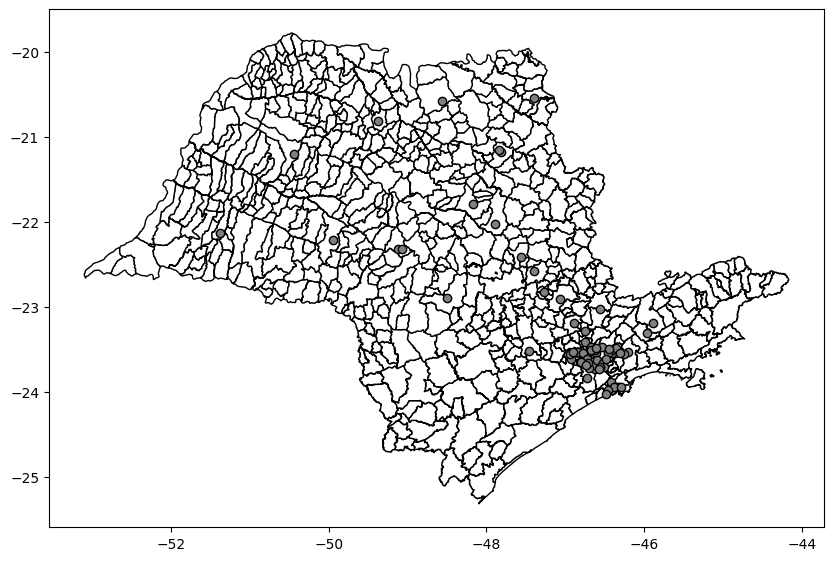

In [11]:
fig, ax = plt.subplots(figsize=(10,8))

# Plotando o mapa dos distritos
cad_unico.plot(ax=ax, color='white', edgecolor='k')

# Plotando os equipamentos esportivos no mesmo ax
bom_prato.plot(ax=ax, color='gray', edgecolor='k')

# # Garantindo que ambos os plots usem os mesmos limites de eixos
# ax.set_xlim(distritos.total_bounds[[0, 2]])  # Definindo limites no eixo x
# ax.set_ylim(distritos.total_bounds[[1, 3]])  # Definindo limites no eixo y

plt.show()

## Mapeamento e Clusterização

In [65]:
merged_df = bom_prato.merge(cad_unico, on='municipio')

In [68]:
merged_df.head(5)

,Item,tipo,endereco,municipio,regiao,lat,long,geometry_x,Cod_ibge,de201,...,ge202,ge203,in101,in201,ra101,ra102,ra103,sn0103,sn0104,geometry_y
0,16,BP_FIXO,"Avenida Antônio Sylvio Cunha Bueno, 1904",Diadema,RMPS,-23.722221,-46.616250,POINT (-46.61625 -23.72222),3513801,13.2,...,47.3,65.6,74.0,5.4,90378,43983,2250,55.6,1119.0,"POLYGON ((-46.6173 -23.65758, -46.61739 -23.65..."
1,46,BP_FIXO,"Rua Dr. Arnaldo Miraglia, nº quadra 06",Bauru,interior,-22.314090,-49.123995,POINT (-49.12399 -22.31409),3506003,8.6,...,46.3,62.1,69.4,13.1,132518,43695,4493,3.7,3402.3,"POLYGON ((-49.15484 -22.06011, -49.15456 -22.0..."
2,47,BP_FIXO,"Rua Mauá, 66",São Paulo,Capital,-23.535079,-46.639350,POINT (-46.63935 -23.53508),3550308,10.9,...,31.8,64.8,73.0,16.0,4671005,1460854,244220,73.1,74073.2,"POLYGON ((-46.55066 -23.35714, -46.55011 -23.3..."
3,66,BP_FIXO,"ETECRI México 70 - Rua do Canal, 582 - Vila Ma...",São Vicente,interior,-23.973035,-46.405382,POINT (-46.40538 -23.97304),3551009,12.9,...,57.9,80.5,71.0,6.0,30928,15606,2775,74.5,1491.0,"POLYGON ((-46.49647 -23.89937, -46.49619 -23.8..."
4,67,BP_FIXO,"Praça Nossa Senhora Aparecida, Vila Nossa Senh...",São Vicente,interior,-23.973035,-46.403922,POINT (-46.40392 -23.97304),3551009,12.9,...,57.9,80.5,71.0,6.0,30928,15606,2775,74.5,1491.0,"POLYGON ((-46.49647 -23.89937, -46.49619 -23.8..."


In [36]:
gdf = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['long'], merged_df['lat']),
    crs="EPSG:4326"  # Sistema de coordenadas WGS84
)

In [37]:
# Escalar os dados de latitude, longitude e a quantidade de famílias
X = gdf[['lat', 'long', 'ge107']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Configurar o modelo K-means para, por exemplo, 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
gdf['cluster'] = kmeans.fit_predict(X_scaled)

In [46]:
gdf.head(5)

,Item,tipo,endereco,municipio,regiao,lat,long,geometry_x,Cod_ibge,de201,...,in101,in201,ra101,ra102,ra103,sn0103,sn0104,geometry_y,geometry,cluster
0,16,BP_FIXO,"Avenida Antônio Sylvio Cunha Bueno, 1904",Diadema,RMPS,-23.722221,-46.616250,POINT (-46.61625 -23.72222),3513801,13.2,...,74.0,5.4,90378,43983,2250,55.6,1119.0,"POLYGON ((-46.6173 -23.65758, -46.61739 -23.65...",POINT (-46.61625 -23.72222),1
1,46,BP_FIXO,"Rua Dr. Arnaldo Miraglia, nº quadra 06",Bauru,interior,-22.314090,-49.123995,POINT (-49.12399 -22.31409),3506003,8.6,...,69.4,13.1,132518,43695,4493,3.7,3402.3,"POLYGON ((-49.15484 -22.06011, -49.15456 -22.0...",POINT (-49.12399 -22.31409),2
2,47,BP_FIXO,"Rua Mauá, 66",São Paulo,Capital,-23.535079,-46.639350,POINT (-46.63935 -23.53508),3550308,10.9,...,73.0,16.0,4671005,1460854,244220,73.1,74073.2,"POLYGON ((-46.55066 -23.35714, -46.55011 -23.3...",POINT (-46.63935 -23.53508),0
3,66,BP_FIXO,"ETECRI México 70 - Rua do Canal, 582 - Vila Ma...",São Vicente,interior,-23.973035,-46.405382,POINT (-46.40538 -23.97304),3551009,12.9,...,71.0,6.0,30928,15606,2775,74.5,1491.0,"POLYGON ((-46.49647 -23.89937, -46.49619 -23.8...",POINT (-46.40538 -23.97304),1
4,67,BP_FIXO,"Praça Nossa Senhora Aparecida, Vila Nossa Senh...",São Vicente,interior,-23.973035,-46.403922,POINT (-46.40392 -23.97304),3551009,12.9,...,71.0,6.0,30928,15606,2775,74.5,1491.0,"POLYGON ((-46.49647 -23.89937, -46.49619 -23.8...",POINT (-46.40392 -23.97304),1


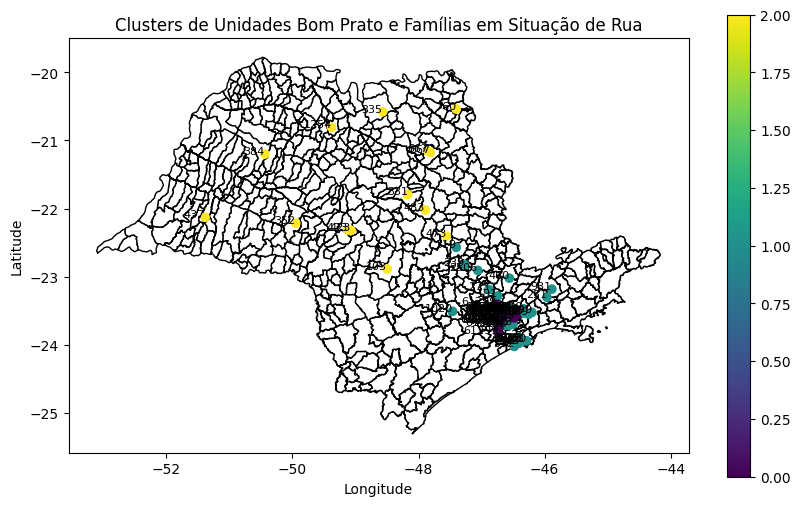

In [45]:
# Plotar os clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cad_unico.plot(ax=ax, color='white', edgecolor='k')
gdf.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['ge107']):
    ax.text(x, y, str(label), fontsize=8, ha='right')

# Títulos e rótulos
plt.title("Clusters de Unidades Bom Prato e Famílias em Situação de Rua")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

**1. Concentração de Serviços na Região Metropolitana:**

A maior concentração de pontos na área próxima a São Paulo (destacada em cores escuras) sugere uma alta densidade de unidades Bom Prato nessa região. Isso pode indicar que há mais famílias em situação de rua e, portanto, uma maior necessidade de atendimento.

**2. Cobertura e Distribuição Regional:**

As regiões mais afastadas da capital, com pontos coloridos em tons de amarelo e verde, indicam que as unidades Bom Prato estão distribuídas, mas em menor quantidade, nas áreas do interior. Isso pode sugerir que, embora haja unidades em diversas regiões, a cobertura é mais esparsa fora da capital e de sua região metropolitana.

**3. Clusters de Alta e Baixa Necessidade:**

Os clusters formados indicam áreas de maior e menor concentração de famílias em situação de rua (baseado nos dados ge107). As cores mais escuras perto da capital provavelmente correspondem a uma demanda maior, enquanto as cores mais claras (como amarelo) indicam áreas de menor concentração e potencialmente menor necessidade de novos pontos de atendimento.

**4. Possíveis Gaps de Atendimento:**

A distribuição indica que algumas regiões mais afastadas e menos densas não possuem muitos pontos de atendimento. Isso pode representar lacunas no serviço que podem ser analisadas para verificar se há uma necessidade de expansão das unidades Bom Prato nessas áreas.

## Regiões Estratégicas

In [47]:
cad_unico['ge107'].describe()

,ge107
count,645.000000
mean,159.818605
std,2418.965273
min,0.000000
25%,0.000000
50%,4.000000
75%,33.000000
max,61299.000000


In [77]:
# Usando percentil para definir o valor limite
percentil_90 = cad_unico['ge107'].quantile(0.90)
percentil_95 = cad_unico['ge107'].quantile(0.95)

# Usando média e desvio padrão
media = cad_unico['ge107'].mean()
desvio_padrao = cad_unico['ge107'].std()
um_desvio_acima = media + desvio_padrao
dois_desvios_acima = media + 2 * desvio_padrao

# focar nas áreas mais críticas.
print("Percentil 90:", percentil_90)
print("Percentil 95:", percentil_95)
# capturar as regiões com vulnerabilidade bem acima da média
print("Média + 1 Desvio Padrão:", um_desvio_acima)
print("Média + 2 Desvios Padrão:", dois_desvios_acima)


Percentil 90: 176.0
Percentil 95: 328.59999999999945
Média + 1 Desvio Padrão: 2578.7838773114668
Média + 2 Desvios Padrão: 4997.749149971771


In [49]:
bom_prato

,Item,tipo,endereco,municipio,regiao,lat,long,geometry
0,16,BP_FIXO,"Avenida Antônio Sylvio Cunha Bueno, 1904",Diadema,RMPS,-23.722221,-46.616250,POINT (-46.61625 -23.72222)
1,46,BP_FIXO,"Rua Dr. Arnaldo Miraglia, nº quadra 06",Bauru,interior,-22.314090,-49.123995,POINT (-49.12399 -22.31409)
2,47,BP_FIXO,"Rua Mauá, 66",São Paulo,Capital,-23.535079,-46.639350,POINT (-46.63935 -23.53508)
3,66,BP_FIXO,"ETECRI México 70 - Rua do Canal, 582 - Vila Ma...",São Vicente,interior,-23.973035,-46.405382,POINT (-46.40538 -23.97304)
4,67,BP_FIXO,"Praça Nossa Senhora Aparecida, Vila Nossa Senh...",São Vicente,interior,-23.973035,-46.403922,POINT (-46.40392 -23.97304)
...,...,...,...,...,...,...,...,...
70,35,BP_FIXO,"Rua Presidente Roosevelt, 126",Limeira,interior,-22.569664,-47.401887,POINT (-47.40189 -22.56966)
71,37,BP_FIXO,"R. Antônio Arenso, 55",São Paulo,Capital,-23.673592,-46.742449,POINT (-46.74245 -23.67359)
72,44,BP_FIXO,"Av. Doutor Vicente de Carvalho, 876",Praia Grande,interior,-24.024066,-46.479923,POINT (-46.47992 -24.02407)
73,49,BP_FIXO,"Avenida Governador Lucas Nogueira Garcez, 500",Ribeirão Preto,interior,-21.157752,-47.846369,POINT (-47.84637 -21.15775)


In [78]:
import geopandas as gpd
from geopy.distance import geodesic
import numpy as np
import pandas as pd

vulnerable_regions = cad_unico
bom_prato_units = bom_prato

# Calculando o centróide de cada município em vulnerable_regions
vulnerable_regions['centroid'] = vulnerable_regions.geometry.centroid
vulnerable_regions[['centroid_lat', 'centroid_long']] = vulnerable_regions['centroid'].apply(
    lambda point: pd.Series({'centroid_lat': point.y, 'centroid_long': point.x})
)

# Definindo as regiões de alta vulnerabilidade com base na coluna 'ge107'
valor_limite = 328  # Defina um limite de vulnerabilidade adequado
high_vulnerability = vulnerable_regions[vulnerable_regions['ge107'] > valor_limite]

# Ajuste para os nomes das colunas de latitude e longitude das unidades Bom Prato
latitude_column_bomprato = 'lat'  # Substitua pelo nome correto, se necessário
longitude_column_bomprato = 'long'  # Substitua pelo nome correto, se necessário

# Função para calcular a menor distância entre uma região vulnerável (centróide) e as unidades Bom Prato
def calcular_menor_distancia(row, bom_prato_units):
    coordenadas_vulneravel = (row['centroid_lat'], row['centroid_long'])
    distancias = bom_prato_units.apply(
        lambda x: geodesic(coordenadas_vulneravel, (x[latitude_column_bomprato], x[longitude_column_bomprato])).kilometers,
        axis=1
    )
    return distancias.min()  # Retorna a menor distância

# Aplicando a função para cada região de alta vulnerabilidade
high_vulnerability['distancia_minima'] = high_vulnerability.apply(
    calcular_menor_distancia, bom_prato_units=bom_prato_units, axis=1
)

# Calculando a distância média
distancia_media = high_vulnerability['distancia_minima'].mean()
print(f"A distância média para a unidade Bom Prato mais próxima nas regiões de alta vulnerabilidade é: {distancia_media:.2f} km")

# Identificando regiões estratégicas (aquelas com maior distância)
# Seleciona as regiões vulneráveis mais distantes das unidades Bom Prato
regioes_estrategicas = high_vulnerability[high_vulnerability['distancia_minima'] > distancia_media]
print("Regiões sugeridas para novas unidades Bom Prato:")
print(regioes_estrategicas[['municipio', 'centroid_lat', 'centroid_long', 'distancia_minima']])


<ipython-input-78-d94762d32e5d>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vulnerable_regions['centroid'] = vulnerable_regions.geometry.centroid


A distância média para a unidade Bom Prato mais próxima nas regiões de alta vulnerabilidade é: 11.45 km
Regiões sugeridas para novas unidades Bom Prato:
               municipio  centroid_lat  centroid_long  distancia_minima
77         Caraguatatuba    -23.639400     -45.488628         61.157200
127                  Itu    -23.306938     -47.284422         28.734396
147           Indaiatuba    -23.105999     -47.202478         26.267635
160              Taubaté    -23.086831     -45.502081         40.608567
238           Piracicaba    -22.726008     -47.783885         42.358717
368  Presidente Prudente    -21.993083     -51.343198         15.656505
395           São Carlos    -21.918552     -47.867029         11.753743
524            Araçatuba    -21.113589     -50.574603         17.297598


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<ipython-input-94-fa9de4705331>:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper left')


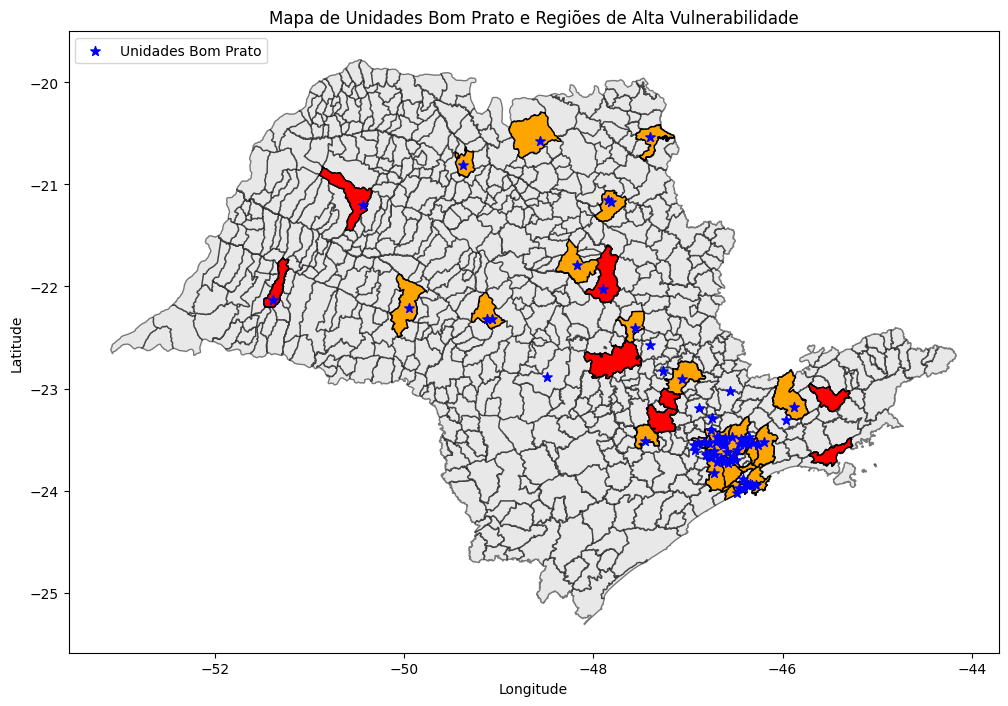

In [94]:
import matplotlib.pyplot as plt

# Plotando o mapa
fig, ax = plt.subplots(figsize=(12, 10))

# Plotar todas as regiões vulneráveis
vulnerable_regions.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plotar as regiões de alta vulnerabilidade
high_vulnerability.plot(ax=ax, color='orange', edgecolor='black', marker='o', label='Alta Vulnerabilidade')

# Plotar as regiões estratégicas (mais distantes)
regioes_estrategicas.plot(ax=ax, color='red', edgecolor='black', marker='o', label='Regiões Estratégicas')

# Plotar as unidades Bom Prato
bom_prato_units.plot(ax=ax, color='blue', marker='*', markersize=50, label='Unidades Bom Prato')

# Personalizando o gráfico
plt.title("Mapa de Unidades Bom Prato e Regiões de Alta Vulnerabilidade")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')

plt.show()

## Usando clusterização para definir regiões estratégicas

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Distância média entre regiões de alta vulnerabilidade e a unidade Bom Prato mais próxima: 3.521131171916676 km


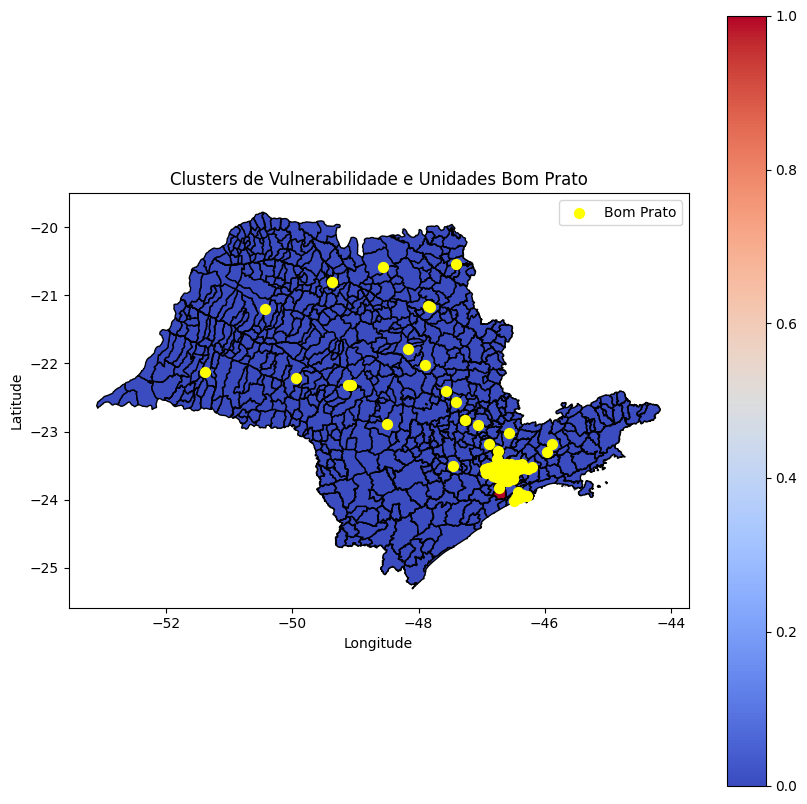

In [102]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from geopy.distance import geodesic
import geopandas as gpd
import matplotlib.pyplot as plt

# Carregar os dados
vulnerable_regions = cad_unico
bom_prato_units = bom_prato

# Aplicar K-Means para agrupar as regiões de vulnerabilidade
# 1. Inicializar e ajustar o modelo
kmeans = KMeans(n_clusters=2, random_state=0)  # 2 clusters: alta e baixa vulnerabilidade
vulnerable_regions['cluster'] = kmeans.fit_predict(vulnerable_regions[['ge107']])

# 2. Identificar qual cluster representa alta vulnerabilidade
# O cluster com média maior de 'ge107' será considerado o cluster de alta vulnerabilidade
cluster_means = vulnerable_regions.groupby('cluster')['ge107'].mean()
high_vulnerability_cluster = cluster_means.idxmax()  # Cluster com maior média de 'ge107'

# 3. Filtrar apenas as regiões com alta vulnerabilidade
high_vulnerability_regions = vulnerable_regions[vulnerable_regions['cluster'] == high_vulnerability_cluster]

# Calcular a distância média para a unidade Bom Prato mais próxima
distancias = []

for _, region in high_vulnerability_regions.iterrows():
    min_distance = np.inf
    region_coords = (region.geometry.centroid.y, region.geometry.centroid.x)

    for _, bp in bom_prato_units.iterrows():
        bom_prato_coords = (bp['lat'], bp['long'])
        distance = geodesic(region_coords, bom_prato_coords).kilometers
        min_distance = min(min_distance, distance)

    distancias.append(min_distance)

# Adicionar a distância mínima ao DataFrame de alta vulnerabilidade
high_vulnerability_regions['distancia_minima'] = distancias

# Calcular a distância média para todas as regiões de alta vulnerabilidade
distancia_media = np.mean(distancias)
print("Distância média entre regiões de alta vulnerabilidade e a unidade Bom Prato mais próxima:", distancia_media, "km")

# Plotar os clusters de vulnerabilidade
fig, ax = plt.subplots(figsize=(10, 10))
vulnerable_regions.plot(ax=ax, column='cluster', cmap='coolwarm', legend=True, edgecolor='black')
bom_prato_units.plot(ax=ax, color='yellow', marker='o', markersize=50, label='Bom Prato')
plt.title("Clusters de Vulnerabilidade e Unidades Bom Prato")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()
